In [1]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2
import pandas as pd



# local files
sys.path.insert(0, '../../')
import pyClient
import utils
import model
from model import Transition
import training

In [2]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 12000       # Port number that the TCP/IP interface listens to

environment =  pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) # or choose # DummyEnvironment()


# Model parameters
BATCH_SIZE = 128 #original 128
GAMMA = 0.9
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY_steps = 4000 
EPS_DECAY = (EPS_START - EPS_END)/EPS_DECAY_steps
REPLAY_START_SIZE =  1500
TARGET_UPDATE = 10 #episodes
DEVICE = 'cuda:1'
MEMORY_CAPACITY = 12000

# agent = model.DoubleDQNAgent(imsize=IMSIZE, 
#                  in_channels=STACK_SIZE,
#                  n_actions=N_ACTIONS,
#                  memory_capacity=MEMORY_CAPACITY,
#                  eps_start=EPS_START,
#                  eps_end=EPS_END,
#                  eps_delta=EPS_DECAY,
#                  gamma_discount = GAMMA,
#                  batch_size = BATCH_SIZE,
#                  device=DEVICE)


# Optimizer Parameters
LR_DQN = 0.01

# optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

In [3]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128, canny_threshold=80):
        """ @TODO 
        - Extended image processing
        """
        
        self.thr_high = canny_threshold
        self.thr_low  = canny_threshold // 2
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if self.simulator is not None:
            frame = cv2.Canny(frame, self.thr_low,self.thr_high)
            frame = self.simulator(frame)
        frame = frame.astype('float32')
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)

def save_replay():
    out = cv2.VideoWriter(os.path.join(OUT_PATH,'{}.avi'.format(model_name)),
                          cv2.VideoWriter_fourcc('M','J','P','G'), 
                          2, (IMSIZE,IMSIZE))
    for i, (state, action, next_state, reward) in enumerate(agent.memory.memory):
        frame = (255*state[0,-1].detach().cpu().numpy()).astype('uint8')
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR )
        frame = cv2.putText(frame,'reward: {:0.1f}'.format(reward.item()),(0,20),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.35,color=(0,0,255))
        frame = cv2.putText(frame,'action: {}'.format(action.item()),(0,10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.35,color=(0,0,255))
        out.write(frame)
    out.release()

In [ ]:
OUT_PATH = 'Out/Exp1b_low_Jan14'
# PROGRESS = pd.read_csv(os.path.join(OUT_PATH,'_exp1_progress.csv'),index_col=0,squeeze=True)

## Training parameters 
MAX_EPISODES = 1200 # number of episodes (an episode ends after agent hits a box)
MAX_STEPS  = 1e7 # number of optimization steps (each time step the model parameters are updated)
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:True,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5
REWARD_MULTIPLIER        = 1.





# Training configuration dictionary
cfg = dict()
# cfg['seed']                     = SEED
# cfg['training_condition']       = TRAINING_CONDITION 
cfg['max_episodes']             = MAX_EPISODES
# cfg['model_path']               = MODEL_PATH
cfg['max_steps']                = MAX_STEPS
cfg['target_update']            = TARGET_UPDATE
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL
cfg['replay_start_size']        = REPLAY_START_SIZE
# cfg['logfile']                  = LOGFILE
cfg['reward_multiplier']        = REWARD_MULTIPLIER


# seed = 0
# complexity = 'plain'

LR_DQN = 0.01
GAMMA = 0.9

for seed in [0,1,2,3,4]: # done: 0,1, ; half-finished: 2
    for edge_threshold in [40, 60, 80, 100, 120]:
        for phosphene_resolution in [42,18]:
             for complexity in ['plain', 'complex']:

                # Condition-specific configuration
                cfg['training_condition'] = 0 if complexity == 'plain' else 1 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
                cfg['seed'] = seed
                torch.manual_seed(seed)
                model_name = 'exp1_{}_thr{}_phos{}_gamma{}_LR{}_S{}'.format(complexity,
                                                                      edge_threshold,
                                                                      phosphene_resolution,
                                                                      GAMMA,
                                                                      LR_DQN,
                                                                      seed)
                model_name = model_name.replace('.', '').replace('+', '').replace(',', '')
                print(model_name)

#                 if PROGRESS[model_name] == 'finished':
#                     print('skipping... (model allready present)')
#                     continue

                cfg['logfile'] = os.path.join(OUT_PATH,'{}_train_stats.csv'.format(model_name))
                cfg['model_path'] = os.path.join(OUT_PATH,'{}_best_model.pth'.format(model_name))

                # Phosphene simulation
                img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution, canny_threshold=edge_threshold)

                # Re-initialize model and optimizer
                agent = model.DoubleDQNAgent(imsize=IMSIZE,
                     in_channels=STACK_SIZE,
                     n_actions=N_ACTIONS,
                     memory_capacity=MEMORY_CAPACITY,
                     eps_start=EPS_START,
                     eps_end=EPS_END,
                     eps_delta=EPS_DECAY,
                     gamma_discount = GAMMA,
                     batch_size = BATCH_SIZE,
                     device=DEVICE)

                optimizer = optim.Adam(agent.policy_net.parameters(), lr = LR_DQN)

                # Start training
                training.train(agent, environment, img_processing, optimizer, cfg)
                print('finished training')
    #             PROGRESS.update({model_name:'finished'})
    #             PROGRESS.to_csv(os.path.join(OUT_PATH,'_exp1_progress.csv'))
                save_replay()


exp1_plain_thr40_phos42_gamma09_LR001_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -380.0
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -380.0
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 975 wall_collisions: 0, box_collisions: 102, endless_loops: 0, total_reward: 5940.0
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 392 wall_collisions: 16, box_collisions: 13, endless_loops: 5, total_reward: 2344.0
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
epi

episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 829 wall_collisions: 12, box_collisions: 18, endless_loops: 3, total_reward: 5992.0
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 1136 wall_collisions: 3, box_collisions: 18, endless_loops: 1, total_reward: 8351.0
new best model
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 965 wall_collisions: 5, box_collisions: 21, endless_loops: 1, total_reward: 7040.0
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, target net updated
step count 1116 wall_collisions: 3, box_collisions: 20, endless_loops: 0, total_reward: 8250.

episode 760, target net updated
episode 770, target net updated
episode 780, target net updated
episode 790, target net updated
step count 1094 wall_collisions: 4, box_collisions: 15, endless_loops: 0, total_reward: 8419.0
episode 800, target net updated
episode 810, target net updated
episode 820, target net updated
episode 830, target net updated
episode 840, target net updated
step count 888 wall_collisions: 8, box_collisions: 8, endless_loops: 1, total_reward: 7003.0
episode 850, target net updated
episode 860, target net updated
episode 870, target net updated
episode 880, target net updated
episode 890, target net updated
step count 1083 wall_collisions: 4, box_collisions: 18, endless_loops: 0, total_reward: 8395.0
episode 900, target net updated
episode 910, target net updated
episode 920, target net updated
episode 930, target net updated
episode 940, target net updated
step count 873 wall_collisions: 25, box_collisions: 11, endless_loops: 2, total_reward: 6509.0
episode 950, t

episode 1160, target net updated
episode 1170, target net updated
episode 1180, target net updated
episode 1190, target net updated
finished training
exp1_plain_thr60_phos42_gamma09_LR001_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -380.0
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -380.0
episode 50, target net updated
episode 60, target net updated
episode 70, target net updated
episode 80, target net updated
episode 90, target net updated
step count 975 wall_collisions: 0, box_collisions: 102, endless_loops: 0, total_reward: 5940.0
new best model
episode 100, target net updated
episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 387 wall_collisions: 35, box_coll

step count 614 wall_collisions: 10, box_collisions: 22, endless_loops: 4, total_reward: 3690.0
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 537 wall_collisions: 7, box_collisions: 18, endless_loops: 5, total_reward: 3528.0
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 546 wall_collisions: 6, box_collisions: 16, endless_loops: 4, total_reward: 3532.0
episode 450, target net updated
episode 460, target net updated
episode 470, target net updated
episode 480, target net updated
episode 490, target net updated
step count 743 wall_collisions: 8, box_collisions: 23, endless_loops: 3, total_reward: 5082.0
episode 500, target net updated
episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, ta

episode 710, target net updated
episode 720, target net updated
episode 730, target net updated
episode 740, target net updated
step count 1095 wall_collisions: 3, box_collisions: 6, endless_loops: 0, total_reward: 8658.0
episode 750, target net updated
episode 760, target net updated
episode 770, target net updated
episode 780, target net updated
episode 790, target net updated
step count 1071 wall_collisions: 1, box_collisions: 10, endless_loops: 0, total_reward: 8590.0
episode 800, target net updated
episode 810, target net updated
episode 820, target net updated
episode 830, target net updated
episode 840, target net updated
step count 1078 wall_collisions: 0, box_collisions: 10, endless_loops: 0, total_reward: 8608.0
episode 850, target net updated
episode 860, target net updated
episode 870, target net updated
episode 880, target net updated
episode 890, target net updated
step count 856 wall_collisions: 3, box_collisions: 4, endless_loops: 2, total_reward: 6824.0
episode 900, ta

step count 1099 wall_collisions: 1, box_collisions: 17, endless_loops: 1, total_reward: 8336.0
episode 1100, target net updated
episode 1110, target net updated
episode 1120, target net updated
episode 1130, target net updated
episode 1140, target net updated
step count 839 wall_collisions: 20, box_collisions: 22, endless_loops: 3, total_reward: 5970.0
episode 1150, target net updated
episode 1160, target net updated
episode 1170, target net updated
episode 1180, target net updated
episode 1190, target net updated
finished training
exp1_plain_thr80_phos42_gamma09_LR001_S0
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -380.0
episode 0, target net updated
episode 10, target net updated
episode 20, target net updated
episode 30, target net updated
episode 40, target net updated
step count 25 wall_collisions: 25, box_collisions: 0, endless_loops: 5, total_reward: -380.0
episode 50, target net updated
episode 60, target net updated
episode 70, target 

episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 809 wall_collisions: 8, box_collisions: 20, endless_loops: 4, total_reward: 5068.0
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 1024 wall_collisions: 21, box_collisions: 28, endless_loops: 1, total_reward: 6404.0
episode 350, target net updated
episode 360, target net updated
episode 370, target net updated
episode 380, target net updated
episode 390, target net updated
step count 1088 wall_collisions: 16, box_collisions: 23, endless_loops: 1, total_reward: 6923.0
new best model
episode 400, target net updated
episode 410, target net updated
episode 420, target net updated
episode 430, target net updated
episode 440, target net updated
step count 578 wall_collisions: 17, box_collisions: 12, endless_loops: 4, total_reward: 412

step count 1074 wall_collisions: 1, box_collisions: 16, endless_loops: 0, total_reward: 8407.0
episode 650, target net updated
episode 660, target net updated
episode 670, target net updated
episode 680, target net updated
episode 690, target net updated
step count 1067 wall_collisions: 0, box_collisions: 20, endless_loops: 0, total_reward: 8308.0
episode 700, target net updated
episode 710, target net updated
episode 720, target net updated
episode 730, target net updated
episode 740, target net updated
step count 951 wall_collisions: 1, box_collisions: 19, endless_loops: 1, total_reward: 7390.0
episode 750, target net updated
episode 760, target net updated
episode 770, target net updated
episode 780, target net updated
episode 790, target net updated
step count 1067 wall_collisions: 4, box_collisions: 16, endless_loops: 0, total_reward: 8372.0
episode 800, target net updated
episode 810, target net updated
episode 820, target net updated
episode 830, target net updated
episode 840, 

episode 1010, target net updated
episode 1020, target net updated
episode 1030, target net updated
episode 1040, target net updated
step count 1084 wall_collisions: 1, box_collisions: 34, endless_loops: 0, total_reward: 7868.0
episode 1050, target net updated
episode 1060, target net updated
episode 1070, target net updated
episode 1080, target net updated
episode 1090, target net updated
step count 922 wall_collisions: 1, box_collisions: 33, endless_loops: 1, total_reward: 6823.0
episode 1100, target net updated
episode 1110, target net updated
episode 1120, target net updated
episode 1130, target net updated
episode 1140, target net updated
step count 863 wall_collisions: 4, box_collisions: 28, endless_loops: 2, total_reward: 6468.0
episode 1150, target net updated
episode 1160, target net updated
episode 1170, target net updated
episode 1180, target net updated
episode 1190, target net updated
finished training
exp1_plain_thr100_phos42_gamma09_LR001_S0
step count 25 wall_collisions:

episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 166 wall_collisions: 0, box_collisions: 5, endless_loops: 5, total_reward: 988.0
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 525 wall_collisions: 10, box_collisions: 29, endless_loops: 4, total_reward: 2788.0
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 261 wall_collisions: 0, box_collisions: 6, endless_loops: 5, total_reward: 1776.0
episode 300, target net updated
episode 310, target net updated
episode 320, target net updated
episode 330, target net updated
episode 340, target net updated
step count 469 wall_collisions: 6, box_collisions: 21, endless_loops: 4, total_reward: 2546.0
episode 350, target net updated
episode 360, targe

episode 560, target net updated
episode 570, target net updated
episode 580, target net updated
episode 590, target net updated
step count 1085 wall_collisions: 1, box_collisions: 7, endless_loops: 0, total_reward: 8666.0
new best model
episode 600, target net updated
episode 610, target net updated
episode 620, target net updated
episode 630, target net updated
episode 640, target net updated
step count 1075 wall_collisions: 1, box_collisions: 8, endless_loops: 0, total_reward: 8646.0
episode 650, target net updated
episode 660, target net updated
episode 670, target net updated
episode 680, target net updated
episode 690, target net updated
step count 1068 wall_collisions: 0, box_collisions: 8, endless_loops: 1, total_reward: 8662.0
episode 700, target net updated
episode 710, target net updated
episode 720, target net updated
episode 730, target net updated
episode 740, target net updated
step count 1085 wall_collisions: 1, box_collisions: 18, endless_loops: 0, total_reward: 8358.0


step count 1108 wall_collisions: 3, box_collisions: 29, endless_loops: 0, total_reward: 7966.0
episode 950, target net updated
episode 960, target net updated
episode 970, target net updated
episode 980, target net updated
episode 990, target net updated
step count 895 wall_collisions: 1, box_collisions: 33, endless_loops: 1, total_reward: 6344.0
episode 1000, target net updated
episode 1010, target net updated
episode 1020, target net updated
episode 1030, target net updated
episode 1040, target net updated
step count 919 wall_collisions: 7, box_collisions: 42, endless_loops: 1, total_reward: 5988.0
episode 1050, target net updated
episode 1060, target net updated
episode 1070, target net updated
episode 1080, target net updated
episode 1090, target net updated
step count 1080 wall_collisions: 1, box_collisions: 35, endless_loops: 0, total_reward: 7897.0
episode 1100, target net updated
episode 1110, target net updated
episode 1120, target net updated
episode 1130, target net updated


episode 110, target net updated
episode 120, target net updated
episode 130, target net updated
episode 140, target net updated
step count 985 wall_collisions: 0, box_collisions: 92, endless_loops: 0, total_reward: 6241.0
new best model
episode 150, target net updated
episode 160, target net updated
episode 170, target net updated
episode 180, target net updated
episode 190, target net updated
step count 363 wall_collisions: 7, box_collisions: 21, endless_loops: 5, total_reward: 2171.0
episode 200, target net updated
episode 210, target net updated
episode 220, target net updated
episode 230, target net updated
episode 240, target net updated
step count 174 wall_collisions: 0, box_collisions: 7, endless_loops: 5, total_reward: 920.0
episode 250, target net updated
episode 260, target net updated
episode 270, target net updated
episode 280, target net updated
episode 290, target net updated
step count 250 wall_collisions: 4, box_collisions: 5, endless_loops: 5, total_reward: 1453.0
epis

episode 510, target net updated
episode 520, target net updated
episode 530, target net updated
episode 540, target net updated
step count 1086 wall_collisions: 1, box_collisions: 20, endless_loops: 0, total_reward: 8286.0
episode 550, target net updated
episode 560, target net updated
episode 570, target net updated
episode 580, target net updated
episode 590, target net updated
step count 1080 wall_collisions: 2, box_collisions: 12, endless_loops: 0, total_reward: 8507.0
episode 600, target net updated
episode 610, target net updated
episode 620, target net updated
episode 630, target net updated
episode 640, target net updated
step count 912 wall_collisions: 5, box_collisions: 23, endless_loops: 1, total_reward: 6813.0
episode 650, target net updated
episode 660, target net updated
episode 670, target net updated
episode 680, target net updated
episode 690, target net updated
step count 1088 wall_collisions: 2, box_collisions: 23, endless_loops: 0, total_reward: 8279.0
episode 700, 

In [167]:
progress

{'exp1_plain_phos5_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos5_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos10_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos10_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos18_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos18_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos26_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos26_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos34_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos34_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos42_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos42_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos50_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos50_gamma09_LR001_S0': 'finished',
 'exp1_plain_phosNone_gamma09_LR001_S0': 'finished',
 'exp1_complex_phosNone_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos5_gamma09_LR001_S1': 'finished',
 'exp1_complex_phos5_gamma09_LR001_S1': 'finished',
 'exp1_plain_phos10_gamma09_LR001_S1': 'finished',
 'exp1_comple

In [163]:
environment.reset()

(0,
 100,
 [17,
  14,
  11,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  17,
  15,
  12,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  18,
  15,
  12,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  18,
  15,
  12,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  17,
  14,
  11,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  18,
  15,
  12,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  19,
  16,
  13,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  19,
  16,
  13,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  19,
  16,
  13,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  19,
  16,
  13,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,
  0,
  0,
  0,
  50,
  20,
  16,
  13,
  54,
  64,
  9,
  0,
  255,
  0,
  123,
  0,
  124,

In [82]:
# model_names = []
# for seed in [0,1, 2,3,4]: # done: 0,1, ; half-finished: 2
#     for phosphene_resolution in [5,10,18,26,34,42,50,None]:
#         for complexity in ['plain', 'complex']:
#                     model_name = 'exp1_{}_phos{}_gamma{}_LR{}_S{}'.format(complexity,
#                                                                   phosphene_resolution,
#                                                                   GAMMA,
#                                                                   LR_DQN,
#                                                                   seed)
#                     model_name = model_name.replace('.', '').replace('+', '').replace(',', '')
#                     model_names.append(model_name)
                    
# progress = {m:'todo' for m in model_names}
# progress.update({m:'finished' for m in model_names[:40]})
# progress.update({m:'finished' for m in model_names[48:57]})
# progress

{'exp1_plain_phos5_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos5_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos10_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos10_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos18_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos18_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos26_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos26_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos34_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos34_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos42_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos42_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos50_gamma09_LR001_S0': 'finished',
 'exp1_complex_phos50_gamma09_LR001_S0': 'finished',
 'exp1_plain_phosNone_gamma09_LR001_S0': 'finished',
 'exp1_complex_phosNone_gamma09_LR001_S0': 'finished',
 'exp1_plain_phos5_gamma09_LR001_S1': 'finished',
 'exp1_complex_phos5_gamma09_LR001_S1': 'finished',
 'exp1_plain_phos10_gamma09_LR001_S1': 'finished',
 'exp1_comple

## Debugging:

#### Visualize replay memory 

In [6]:
# EXAMPLES = 10

# i = 0
# bad_choices = [(state, action, next_state,reward) for (state, action, next_state,reward) in agent.memory.memory]# if reward<0 and action ==0]
# # for state, action, next_state, reward in agent.memory.memory[:EXAMPLES]:
# for state, action, next_state, reward in bad_choices[:EXAMPLES]:
#     i+=1
    
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward.item()))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
    
# # plt.tight_layout()


#### Inspecting q-value predictions

In [7]:
# state_action_values, expected_state_action_values = agent.forward()
# transitions = agent.memory.sample(agent.batch_size)
# # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
# # detailed explanation). This converts batch-array of Transitions
# # to Transition of batch-arrays.
# batch = Transition(*zip(*transitions))

# # Compute a mask of non-final states and concatenate the batch elements
# # (a final state would've been the one after which simulation ended)
# non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                       batch.next_state)), device=agent.device, dtype=torch.bool)
# non_final_next_states = torch.cat([s for s in batch.next_state
#                                             if s is not None])
# state_batch = torch.cat(batch.state)
# action_batch = torch.cat(batch.action)
# reward_batch = torch.cat(batch.reward)

# # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
# # columns of actions taken. These are the actions which would've been taken
# # for each batch state according to policy_net
# pred = agent.policy_net(state_batch)

# EXAMPLES = 50

# actions = action_batch[:EXAMPLES].detach().cpu().numpy()
# rewards = reward_batch[:EXAMPLES].detach().cpu().numpy()
# predicted = pred[:EXAMPLES].detach().cpu().numpy().squeeze()
# obtained = np.zeros((EXAMPLES,3))
# for i in range(EXAMPLES):
#     obtained[i,actions[i]] = rewards[i]

# plt.figure(figsize=(10,10),dpi=100)
# plt.subplot(1,2,1)
# plt.imshow(predicted)
# plt.subplot(1,2,2)
# plt.imshow(obtained)
# plt.show()

#### Visualize an episode

In [8]:
# Reset environment at start of episode
seed = torch.randint(250,(1,)).item()
_, _, _ = environment.setRandomSeed(seed)
_, _, _ = environment.reset(cfg['training_condition'])

# Create an empty frame stack and fill it with frames
frame_stack = utils.FrameStack(stack_size=cfg['stack_size'] )
for _ in range(cfg['stack_size'] ):
    _, _, frame_raw = environment.step(0)
    frame = img_processing(frame_raw).to(agent.device) 
    state = frame_stack.update_with(frame)

In [9]:
# for t in count(): 

#     agent.policy_net.eval()
#     # Agent performs a step (based on the current state) and obtains next state
#     action = agent.select_action(state)
#     end, reward, frame_raw = environment.step(action.item())
#     agent_died = cfg['reset_upon_end_signal'][end] # or side_steps > cfg['reset_after_nr_sidesteps']
#     frame = img_processing(frame_raw).to(agent.device)
#     next_state = frame_stack.update_with(frame) if not agent_died else None
#     pred = agent.policy_net(state).argmax(axis=1)
    
#     # Interpret reward signal
#     if reward > 100:
#         reward = -(reward -100)
#     reward /= 10
    
#     # Visualize state and print pred, action and reward
#     plt.figure(figsize = (10,10), dpi=200)
#     img = torch.cat([state[0,t,...] for t in range(STACK_SIZE)],dim=1)
#     if next_state is not None:
#         img = torch.cat([img, next_state[0,-1,...]],dim=1)
#         plt.axvline(x=STACK_SIZE*IMSIZE,color='r')
#     plt.imshow(img.detach().cpu().numpy())
#     plt.title('Action: {}, Reward {}'.format(action.item(),reward))
#     plt.axis('off')
#     plt.ylabel('frames >')
#     plt.xlabel('state | next state')
#     plt.show()
#     print('Pred: {}'.format(pred.item()))
#     print('Action: {}'.format(action.item()))
#     print('Reward: {}\n'.format(reward))

#     # the episode ends here if agent performed any 'lethal' action (specified in RESET_UPON_END_SIGNAL)
#     if agent_died:
#         break
#     else:
#         state = next_state


#### Toy environment for debugging

In [10]:
# class DummyEnvironment:
#     def __init__(self, ip = "127.0.0.1", port = 13000, size = 128, channels=16):
#         self.size = size
#         self.channels = channels
#         self._maxSteps = 100
#         self.reset()
 
#     def reset(self, kind=0):
#         self._state = 1
#         self._steps = 0
#         return self._receive()

#     def step(self, action):
#         self._state = -self._state
#         self._steps += 1
#         return self._receive(action)
    
#     def setRandomSeed(self, action):
#         return self._receive()

#     def _receive(self,action=0):
#         end    = 0 if self._steps < self._maxSteps else 3
#         reward = {0:-self._state, 1:self._state, 2:-2}[action]
#         state  = [150-100*self._state for _ in range(262144)] # raw state
#         return end, reward, state
    
#     def state2arrays(self,state):
#         if self.channels == 3:
#             return {'colors' : self.state2usableArray(state),}
        
#         else:
#             state  = np.array(state, "uint8").reshape(self.size, self.size, self.channels)
#             arrays = {'colors' : state[...,:3],
#                     'objseg' : state[...,3:6],
#                     'semseg': state[...,6:9],
#                     'normals'   : state[...,9:12],
#                     'flow'   : state[...,12:15],
#                     'depth'  : state[...,15]}
#             return arrays
    
#     def state2usableArray(self, state):
#         return np.array(state, "uint8").reshape(self.size, self.size, 16)[...,:3]

## Validation:

#### Fast evaluation of trained model

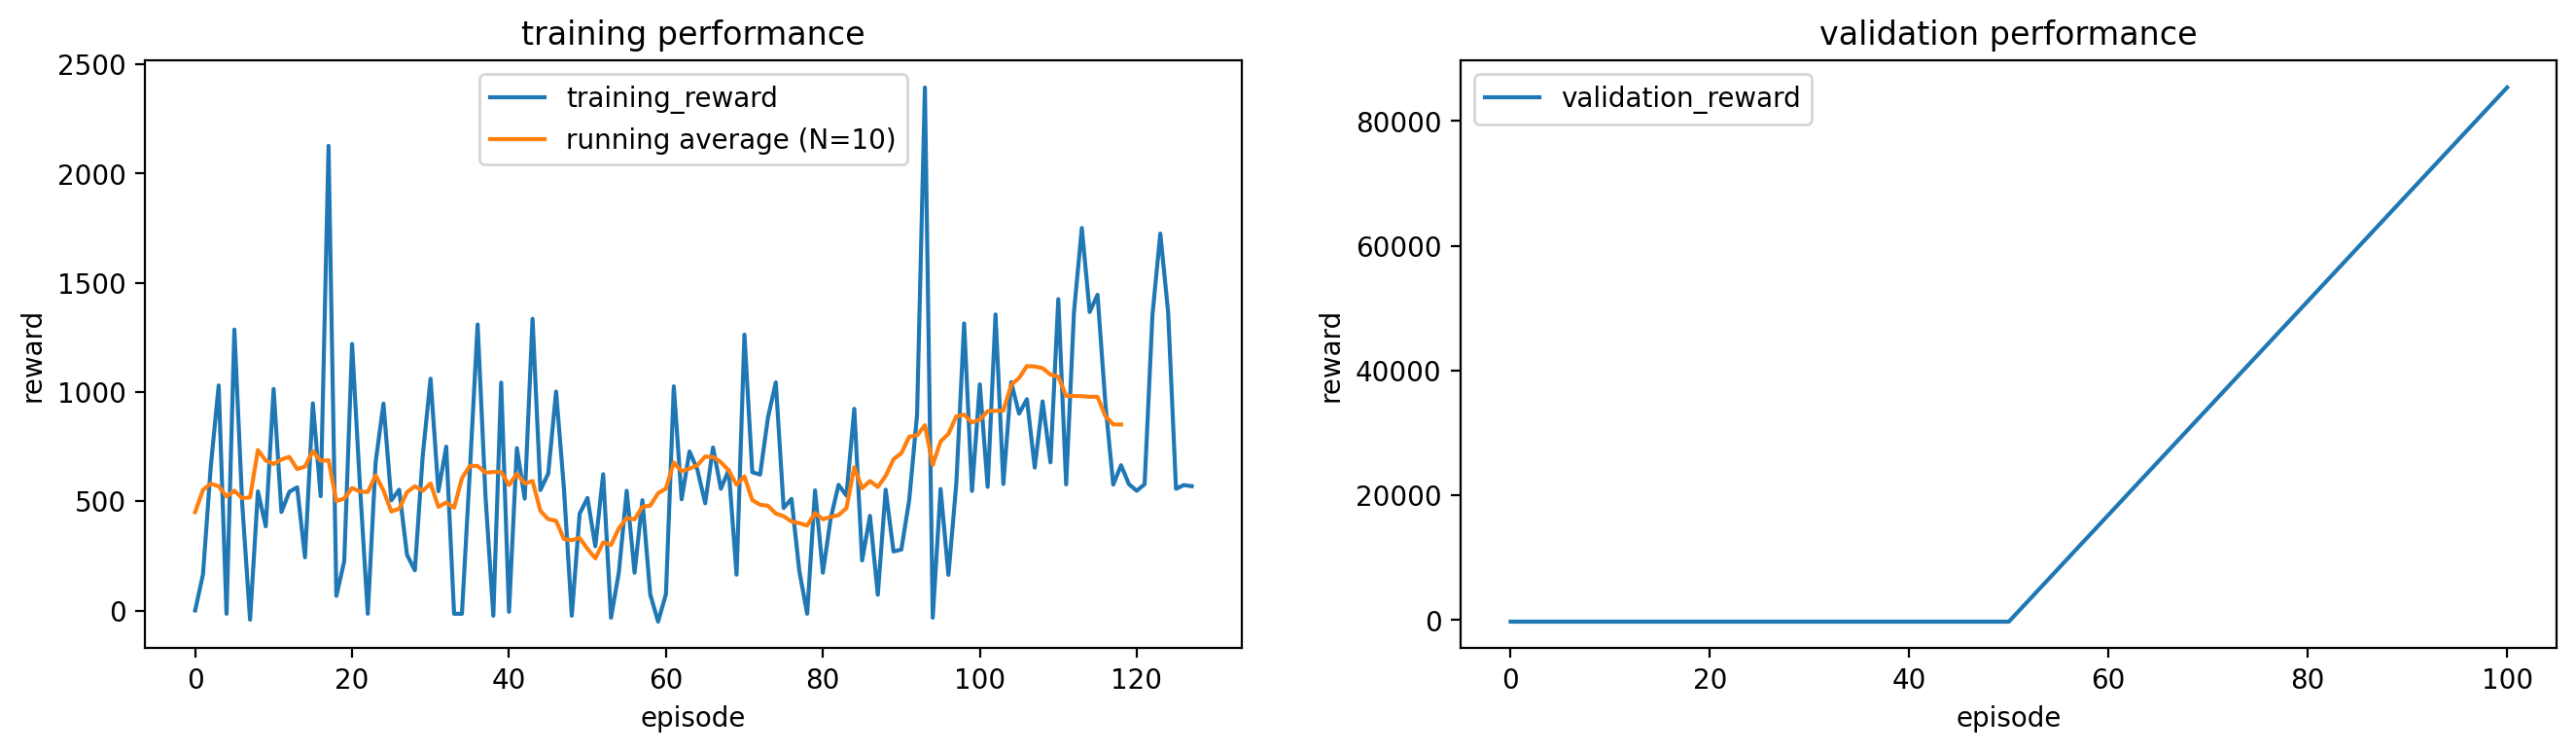

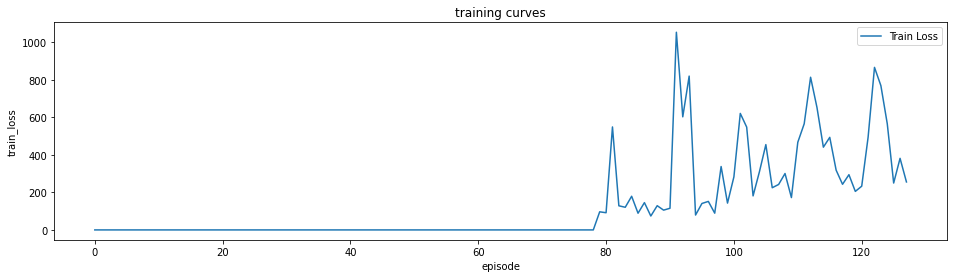

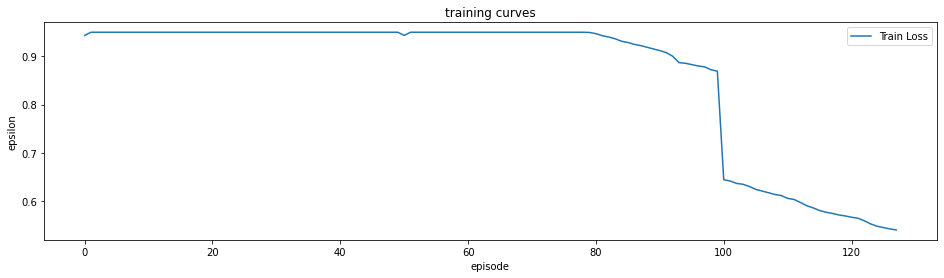

In [157]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MODEL_NAME = 'exp1_complex_phos34_gamma09_LR001_S3'

# exp1_plain_phos34_gamma09_LR001_S0
# exp1_complex_phos34_gamma09_LR001_S0
# exp1_plain_phos42_gamma09_LR001_S0
# exp1_complex_phos42_gamma09_LR001_S0
# exp1_plain_phos50_gamma09_LR001_S0
# exp1_plain_phosNone_gamma09_LR001_S1
# exp1_complex_phosNone_gamma09_LR001_S1
# exp1_plain_phos5_gamma09_LR001_S2
# exp1_complex_phos5_gamma09_LR001_S2
# exp1_plain_phos10_gamma09_LR001_S2
# exp1_complex_phos10_gamma09_LR001_S2
# exp1_plain_phos18_gamma09_LR001_S2
# exp1_complex_phos18_gamma09_LR001_S2

stats = pd.read_csv(os.path.join(OUT_PATH,'{}_train_stats.csv'.format(MODEL_NAME)))

plt.figure(figsize = (16,4),dpi=200)
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='train_loss')
plt.title('training curves')
plt.legend(['Train Loss'])

plt.figure(figsize = (16,4))
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='epsilon')
plt.title('training curves')
plt.legend(['Train Loss'])

### Further testing and evaluation:

In [172]:
import torch
import cv2
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# # local files
sys.path.insert(0, '../../')
import pyClient
import utils
import model
from model import Transition
from testing import test
import testing
import training

OUT_PATH = 'Out/Exp1_Nov22'

In [173]:
# Image processing
class ImageProcessor(object):
    def __init__(self, phosphene_resolution=None, imsize=128, canny_threshold=70):
        """ @TODO 
        - Extended image processing
        """
        
        self.thr_high = canny_threshold
        self.thr_low  = canny_threshold // 2
        self.imsize = imsize
        if phosphene_resolution is not None:
            self.simulator = utils.PhospheneSimulator(phosphene_resolution=(phosphene_resolution,phosphene_resolution),
                                                     size=(128,128),
                                                     jitter=0.25,
                                                     intensity_var=0.9,
                                                     aperture=.66,
                                                     sigma=0.60,)
        else: 
            self.simulator = None
    
    def __call__(self,state_raw,):
        frame = environment.state2usableArray(state_raw)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if self.simulator is not None:
            frame = cv2.Canny(frame, self.thr_low,self.thr_high)
            frame = self.simulator(frame)
        frame = frame.astype('float32')
        return torch.Tensor(frame / 255.).view(1,1,self.imsize, self.imsize)

def save_replay(out_path):
    out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc('M','J','P','G'), 2, (IMSIZE,IMSIZE))
    for i, (state, action, next_state, reward) in enumerate(agent.memory.memory):
        frame = (255*state[0,-1].detach().cpu().numpy()).astype('uint8')
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR )
        frame = cv2.putText(frame,'reward: {:0.1f}'.format(reward.item()),(0,20),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.35,color=(0,0,255))
        frame = cv2.putText(frame,'action: {}'.format(action.item()),(0,10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.35,color=(0,0,255))
        out.write(frame)
    out.release()

In [3]:
import math
import datetime
import os, sys
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from IPython.display import Audio
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchsummary import summary

import cv2




# local files
sys.path.insert(0, '../')
import pyClient
import utils
import model
from model import Transition

def validation_loop(agent,environment,img_processing, cfg, val_seeds=[251,252,253,254,255]):
    # How to handle the different end signals
    RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                             1:False,   # Box collision
                             2:False,   # Wall collision
                             3:True}    # Reached step target
    
    # Set nn.module to evaluation mode
    agent.policy_net.eval()
    
    # Reset counters 
    wall_collisions = 0
    box_collisions = 0
    total_reward = 0
    endless_loops = 0
    step_count = 0
    

    for seed in val_seeds:

        # Reset environment at start of episode
        _, _, _ = environment.setRandomSeed(seed)
        _, _, _ = environment.reset(cfg['training_condition'])

        
        # Create an empty frame stack and fill it with frames
        frame_stack = utils.FrameStack(stack_size=cfg['stack_size'] )
        for _ in range(cfg['stack_size'] ):
            _, _, frame_raw = environment.step(0)
            frame = img_processing(frame_raw).to(agent.device) 
            state = frame_stack.update_with(frame)
        
        side_steps = 0

        # Episode starts here:
        for t in count(): 

            # 1. Agent performs a step (based on the current state) and obtains next state
            action = agent.select_action(state,validation=True)
            end, reward, next_state_raw = environment.step(action.item())
            frame = img_processing(next_state_raw).to(agent.device) 
            next_state = frame_stack.update_with(frame)
            side_steps = side_steps + 1  if action != 0 else 0
            
            # 2. interpret reward
            if reward > 100:
                reward = -(reward -100)
            reward /= 10

                
            # 3. Store performance and training measures
            total_reward += reward;
            if end == 1:
                box_collisions += 1
            if end == 2:
                wall_collisions +=1
            
            reward = torch.tensor([reward], device=agent.device,dtype=torch.float)
            agent.memory.push(state, action, next_state, reward) ### THIS SHOULD NOT BE IN THE TRAINING CODE!!!

            # 4. the episode ends here after reaching step target or too many side steps
            if side_steps>cfg['reset_after_nr_sidesteps']:
                endless_loops += 1
                step_count += t
                break
            elif RESET_UPON_END_SIGNAL[end]:
                step_count += t
                break
            else:
                state = next_state
                
    print('step count {} wall_collisions: {}, box_collisions: {}, endless_loops: {}, total_reward: {}'.format(step_count, wall_collisions, box_collisions, endless_loops, total_reward))
    return step_count, wall_collisions, box_collisions, endless_loops, total_reward

#### Run models on test environment:

In [175]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

# environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 128 #original 128
DEVICE = 'cuda:0'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

test_data = []

complexity = 'plain'
seed = 0

GAMMA = 0.9
LR_DQN = 0.01

for seed in [0,1,2,3,4,]:
    for phosphene_resolution in [5,10,18,26,34,42,50,None]:
            for complexity in ['plain', 'complex']:

                # Condition-specific configuration
                cfg['training_condition']       = 2 if complexity == 'plain' else 3 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
                img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)
                model_name = 'exp1_{}_phos{}_gamma{}_LR{}_S{}'.format(complexity,
                                                      phosphene_resolution,
                                                      GAMMA,
                                                      LR_DQN,
                                                      seed)
                model_name = model_name.replace('.', '').replace('+', '').replace(',', '')
                print(model_name)
                
                # Re-initialize agent 
                agent = model.DoubleDQNAgent(imsize=IMSIZE,
                     in_channels=STACK_SIZE,
                     n_actions=N_ACTIONS,
                     device=DEVICE)
                
                # Load model parameters
                model_path = os.path.join(OUT_PATH,'{}_best_model.pth'.format(model_name))
                agent.policy_net.load_state_dict(torch.load(model_path,map_location=DEVICE))
                agent.policy_net.eval()

                # Testing
                conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed,
                                                      'gamma': GAMMA, 'learning_rate':LR_DQN}
                results = testing.test(agent, environment, img_processing, cfg)
                test_data.append({**conditions,**results})
                video_path = os.path.join(OUT_PATH,'test_{}.avi'.format(model_name))
                save_replay(video_path)
data = pd.DataFrame(test_data)
data.to_csv(os.path.join(OUT_PATH,'_test_results.csv'), index=False)

exp1_plain_phos5_gamma09_LR001_S0
exp1_complex_phos5_gamma09_LR001_S0
exp1_plain_phos10_gamma09_LR001_S0
exp1_complex_phos10_gamma09_LR001_S0
exp1_plain_phos18_gamma09_LR001_S0
exp1_complex_phos18_gamma09_LR001_S0
exp1_plain_phos26_gamma09_LR001_S0
exp1_complex_phos26_gamma09_LR001_S0
exp1_plain_phos34_gamma09_LR001_S0
exp1_complex_phos34_gamma09_LR001_S0
exp1_plain_phos42_gamma09_LR001_S0
exp1_complex_phos42_gamma09_LR001_S0
exp1_plain_phos50_gamma09_LR001_S0
exp1_complex_phos50_gamma09_LR001_S0
exp1_plain_phosNone_gamma09_LR001_S0
exp1_complex_phosNone_gamma09_LR001_S0
exp1_plain_phos5_gamma09_LR001_S1
exp1_complex_phos5_gamma09_LR001_S1
exp1_plain_phos10_gamma09_LR001_S1
exp1_complex_phos10_gamma09_LR001_S1
exp1_plain_phos18_gamma09_LR001_S1
exp1_complex_phos18_gamma09_LR001_S1
exp1_plain_phos26_gamma09_LR001_S1
exp1_complex_phos26_gamma09_LR001_S1
exp1_plain_phos34_gamma09_LR001_S1
exp1_complex_phos34_gamma09_LR001_S1
exp1_plain_phos42_gamma09_LR001_S1
exp1_complex_phos42_gamma09_L

In [8]:
data = pd.DataFrame(test_data)
data.to_csv(os.path.join(OUT_PATH,'_test_results.csv'), index=False)


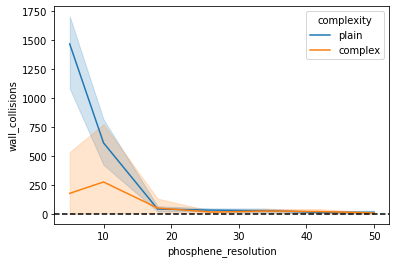

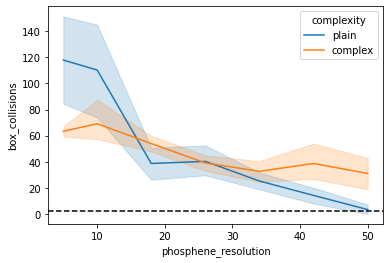

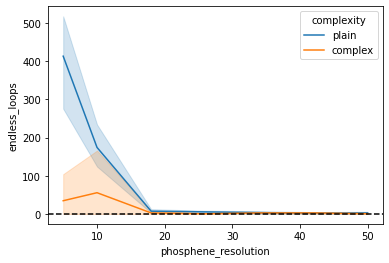

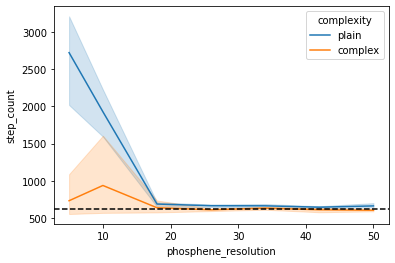

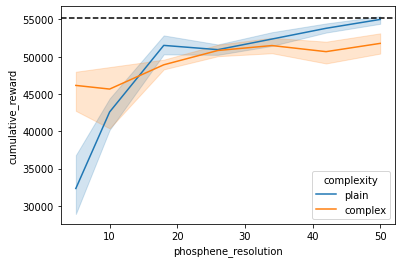

In [176]:
for y in ['wall_collisions','box_collisions','endless_loops','step_count', 'cumulative_reward']:
    sns.lineplot(data=data, x='phosphene_resolution', y=y, hue='complexity')
    plt.axhline(y=data[data.phosphene_resolution.isnull()].mean()[y], color='k', linestyle='--')
#     plt.ylim([-5,100])
    plt.show()

55256.0

In [35]:
# Environment parameters
IMSIZE = 128
STACK_SIZE = 4
N_ACTIONS = 3
IP  = "127.0.0.1" # Ip address that the TCP/IP interface listens to
PORT = 13000       # Port number that the TCP/IP interface listens to

environment = pyClient.Environment(ip = IP, port = PORT, size = IMSIZE) 

# Model parameters
BATCH_SIZE = 128 #original 128
DEVICE = 'cuda:0'

agent = model.DoubleDQNAgent(imsize=IMSIZE,
                 in_channels=STACK_SIZE,
                 n_actions=N_ACTIONS,
                 device=DEVICE)


## Testing parameters 
RESET_UPON_END_SIGNAL = {0:False,  # Nothing happened
                         1:False,   # Box collision
                         2:False,   # Wall collision
                         3:True}  # Reached step target
RESET_AFTER_NR_SIDESTEPS = 5


# Testing configuration dictionary
cfg = dict()
cfg['stack_size']               = STACK_SIZE
cfg['reset_after_nr_sidesteps'] = RESET_AFTER_NR_SIDESTEPS
cfg['reset_upon_end_signal']    = RESET_UPON_END_SIGNAL

val_data = []
# for complexity in ['plain', 'complex']:
#     for phosphene_resolution in [ 50,42,34,26,18,10]: # None
#         for seed in [0,1,2,3,4]:


complexity = 'plain'
seed = 0

GAMMAs = [0.5, 0.9, 0.99]
LRs = [0.005, 0.01, 0.05, 0.1]

LR_DQN = 0.01

for seed in [0,1]:
    for phosphene_resolution in [5,10,18,26,34,42,50,None]:
        for GAMMA in [0.5,0.9]:
            for complexity in ['plain', 'complex']:


                model_name = 'exp1_{}_phos{}_gamma{}_LR{}_S{}'.format(complexity,
                                                                      phosphene_resolution,
                                                                      GAMMA,
                                                                      LR_DQN,
                                                                      seed)
                model_name = model_name.replace('.', '').replace('+', '').replace(',', '')
                model_path = os.path.join(OUT_PATH,'{}_best_model.pth'.format(model_name))

                # Condition-specific configuration
                cfg['training_condition']       = 0 if complexity == 'plain' else 1 # 0: plain training, 1: complex training, 2: plain testing 3: complex testing
                print(model_name)

                # Phosphene simulation
                img_processing = ImageProcessor(phosphene_resolution = phosphene_resolution)

                # Re-initialize model and optimizer
                agent = model.DoubleDQNAgent(imsize=IMSIZE,
                     in_channels=STACK_SIZE,
                     n_actions=N_ACTIONS,
                     device=DEVICE)
                agent.policy_net.load_state_dict(torch.load(model_path,map_location=DEVICE))
                agent.policy_net.eval()

                # Validation
                conditions = {'complexity': complexity, 'phosphene_resolution': phosphene_resolution, 'seed' : seed,
                             'gamma': GAMMA, 'learning_rate':LR_DQN}
    #             results = training.validation_loop(agent, environment, img_processing, cfg)
                results = validation_loop(agent, environment, img_processing, cfg)
                video_path = os.path.join(OUT_PATH,'val2_{}.avi'.format(model_name))
                save_replay(video_path)

                results = {k:results[i] for i, k in enumerate(['step_count',
                                                               'wall_collisions',
                                                               'box_collisions', 
                                                               'endless_loops',
                                                               'total_reward'])}

            
                val_data.append({**conditions,**results})
data = pd.DataFrame(val_data)
data.to_csv(os.path.join(OUT_PATH,'_val_results.csv'), index=False)

exp1_plain_phos5_gamma05_LR001_S0
step count 740 wall_collisions: 52, box_collisions: 64, endless_loops: 5, total_reward: 417.09999999999997
exp1_complex_phos5_gamma05_LR001_S0
step count 2475 wall_collisions: 0, box_collisions: 246, endless_loops: 0, total_reward: 1687.0
exp1_plain_phos5_gamma09_LR001_S0
step count 78 wall_collisions: 39, box_collisions: 3, endless_loops: 5, total_reward: -9.5
exp1_complex_phos5_gamma09_LR001_S0
step count 2475 wall_collisions: 0, box_collisions: 246, endless_loops: 0, total_reward: 1687.0
exp1_plain_phos10_gamma05_LR001_S0
step count 1716 wall_collisions: 56, box_collisions: 166, endless_loops: 2, total_reward: 998.7999999999986
exp1_complex_phos10_gamma05_LR001_S0
step count 184 wall_collisions: 19, box_collisions: 9, endless_loops: 5, total_reward: 19.49999999999998
exp1_plain_phos10_gamma09_LR001_S0
step count 34 wall_collisions: 14, box_collisions: 0, endless_loops: 5, total_reward: -14.299999999999994
exp1_complex_phos10_gamma09_LR001_S0
step co

step count 1459 wall_collisions: 13, box_collisions: 25, endless_loops: 4, total_reward: 1211.2000000000012
exp1_complex_phos50_gamma09_LR001_S1
step count 2640 wall_collisions: 2, box_collisions: 142, endless_loops: 0, total_reward: 1989.5000000000057
exp1_plain_phosNone_gamma05_LR001_S1
step count 2745 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 2398.000000000012
exp1_complex_phosNone_gamma05_LR001_S1
step count 2732 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 2399.300000000011
exp1_plain_phosNone_gamma09_LR001_S1
step count 2735 wall_collisions: 2, box_collisions: 5, endless_loops: 0, total_reward: 2382.200000000011
exp1_complex_phosNone_gamma09_LR001_S1
step count 2726 wall_collisions: 0, box_collisions: 0, endless_loops: 0, total_reward: 2399.900000000011


In [56]:
agent.memory.memory

[]

#### Training and validation curves

In [18]:
import pandas as pd

all_stats = pd.DataFrame()
best_stats = pd.DataFrame()

complexity = 'plain'
seed = 0

# GAMMAs = [0.5, 0.9, 0.99]
# LRs = [0.005, 0.01, 0.05, 0.1]

LR_DQN = 0.01

for seed in [0,1]:
    for phosphene_resolution in [5,10,18,26,34,42,50,None]:
        for GAMMA in [0.5,0.9]:
            for complexity in ['plain', 'complex']:

# for phosphene_resolution in  [42,50]:
#     for GAMMA in GAMMAs:
#         for LR_DQN in LRs:
                model_name = 'exp1_{}_phos{}_gamma{}_LR{}_S{}'.format(complexity,
                                                                      phosphene_resolution,
                                                                      GAMMA,
                                                                      LR_DQN,
                                                                      seed)
                model_name = model_name.replace('.', '').replace('+', '').replace(',', '')

                train_csv = os.path.join(OUT_PATH,'{}_train_stats.csv'.format(model_name))
                train_stats = pd.read_csv(train_csv)
                train_stats['complexity'] = complexity
                train_stats['resolution'] = phosphene_resolution
                train_stats['seed'] = seed
                train_stats['model_name'] = model_name

                train_stats['gamma'] = GAMMA
                train_stats['learning_rate'] = LR_DQN

                # Smooth reward and loss
                train_stats.loc[train_stats['validation']==0,'smooth_reward']  = np.convolve(train_stats.loc[train_stats.validation==0].reward,np.ones(20)/20,mode='same')
                train_stats.loc[train_stats['validation']==0,'smooth_loss']  = np.convolve(train_stats.loc[train_stats.validation==0].train_loss,np.ones(20)/20,mode='same')



                # append all rows
                all_stats = all_stats.append(train_stats,ignore_index=True)

                # append only best-performing validation row
                val = train_stats.loc[train_stats.validation==1].reset_index()
                best_stats = best_stats.append(val.iloc[[val.reward.idxmax()]], ignore_index=True)


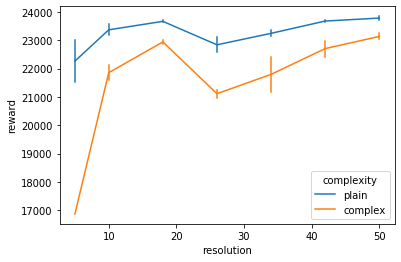

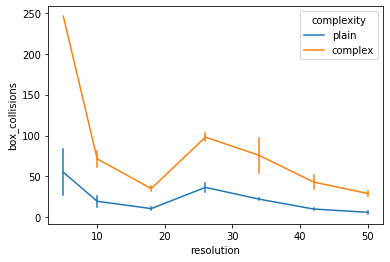

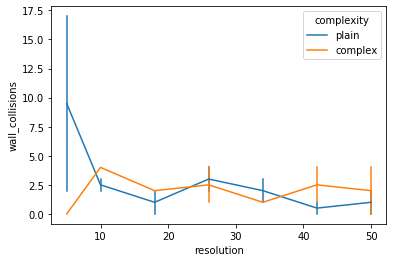

In [32]:
gamma = 0.5
for y in ['reward', 'box_collisions', 'wall_collisions']:
    data = best_stats.loc[(best_stats.validation==1) & (best_stats.gamma==gamma) ]
    sns.lineplot(data=data, x='resolution', y=y, hue='complexity',err_style='bars' )
    plt.show()

In [24]:
best_stats

,index,episode,step_count,wall_collisions,box_collisions,endless_loops,reward,epsilon,train_loss,validation,complexity,resolution,seed,model_name,gamma,learning_rate,smooth_reward,smooth_loss
0,969,950,2712,2,83,0,21516.0,0.0,0.0,1,plain,5,0,exp1_plain_phos5_gamma05_LR001_S0,0.5,0.01,NaN,NaN
1,102,100,2475,0,246,0,16870.0,0.0,0.0,1,complex,5,0,exp1_complex_phos5_gamma05_LR001_S0,0.5,0.01,NaN,NaN
2,714,700,2740,17,56,1,20689.0,0.0,0.0,1,plain,5,0,exp1_plain_phos5_gamma09_LR001_S0,0.9,0.01,NaN,NaN
3,102,100,2475,0,246,0,16870.0,0.0,0.0,1,complex,5,0,exp1_complex_phos5_gamma09_LR001_S0,0.9,0.01,NaN,NaN
4,969,950,2748,2,26,0,23179.0,0.0,0.0,1,plain,10,0,exp1_plain_phos10_gamma05_LR001_S0,0.5,0.01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,714,700,2747,6,34,1,22970.0,0.0,0.0,1,complex,50,1,exp1_complex_phos50_gamma09_LR001_S1,0.9,0.01,NaN,NaN
60,816,800,2745,0,0,0,23980.0,0.0,0.0,1,plain,None,1,exp1_plain_phosNone_gamma05_LR001_S1,0.5,0.01,NaN,NaN
61,918,900,2732,0,0,0,23993.0,0.0,0.0,1,complex,None,1,exp1_complex_phosNone_gamma05_LR001_S1,0.5,0.01,NaN,NaN
62,714,700,2735,2,5,0,23822.0,0.0,0.0,1,plain,None,1,exp1_plain_phosNone_gamma09_LR001_S1,0.9,0.01,NaN,NaN


In [19]:
all_stats

,episode,step_count,wall_collisions,box_collisions,endless_loops,reward,epsilon,train_loss,validation,complexity,resolution,seed,model_name,gamma,learning_rate,smooth_reward,smooth_loss
0,0,2510,30,245,0,16595.0,0.00000,0.000000,1,plain,5,0,exp1_plain_phos5_gamma05_LR001_S0,0.5,0.01,NaN,NaN
1,0,0,0,0,0,0.0,0.38435,0.000000,0,plain,5,0,exp1_plain_phos5_gamma05_LR001_S0,0.5,0.01,11.25,0.000000
2,1,22,4,1,0,33.0,0.95000,0.000000,0,plain,5,0,exp1_plain_phos5_gamma05_LR001_S0,0.5,0.01,9.60,0.000000
3,2,14,4,0,1,5.0,0.95000,0.000000,0,plain,5,0,exp1_plain_phos5_gamma05_LR001_S0,0.5,0.01,10.30,0.000000
4,3,23,4,1,0,43.0,0.95000,0.000000,0,plain,5,0,exp1_plain_phos5_gamma05_LR001_S0,0.5,0.01,9.05,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65275,995,117,2,1,0,935.0,0.05000,71.837633,0,complex,None,1,exp1_complex_phosNone_gamma09_LR001_S1,0.9,0.01,1520.80,119.781678
65276,996,129,1,1,0,1108.0,0.05000,88.990684,0,complex,None,1,exp1_complex_phosNone_gamma09_LR001_S1,0.9,0.01,1465.70,115.151071
65277,997,516,5,1,0,4414.0,0.05000,328.500398,0,complex,None,1,exp1_complex_phosNone_gamma09_LR001_S1,0.9,0.01,1447.85,113.735702
65278,998,178,4,1,0,1516.0,0.05000,94.303225,0,complex,None,1,exp1_complex_phosNone_gamma09_LR001_S1,0.9,0.01,1336.70,103.955644


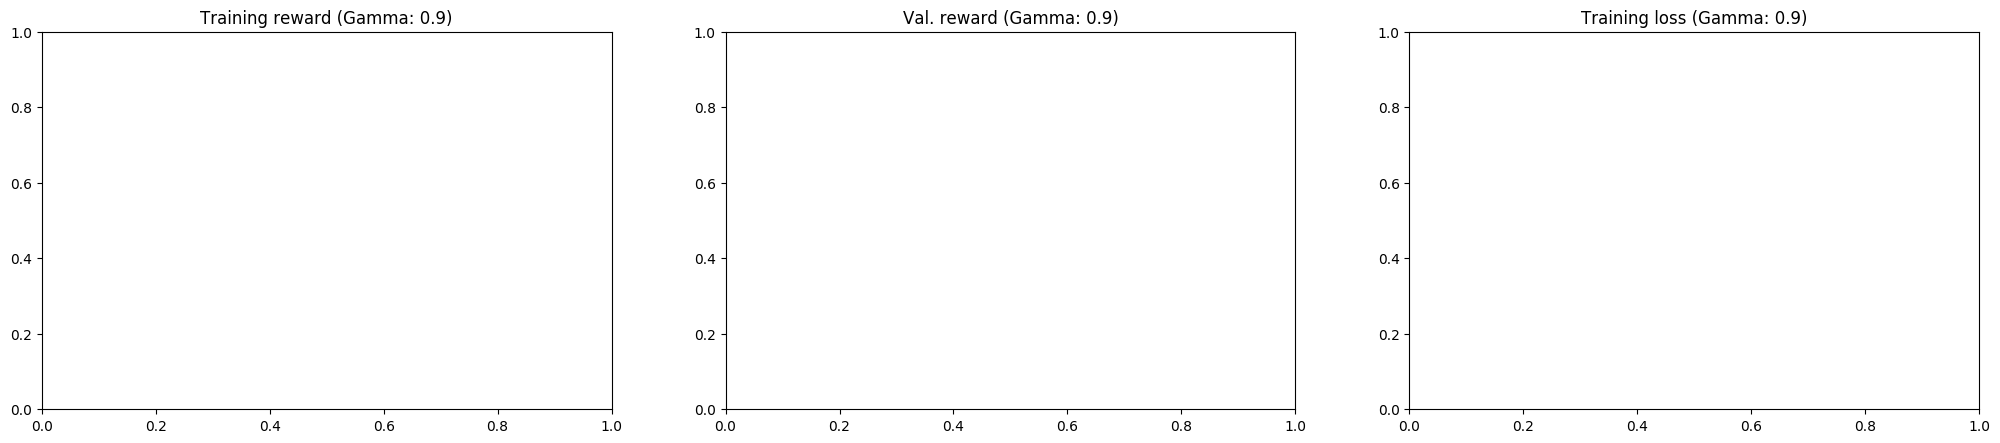

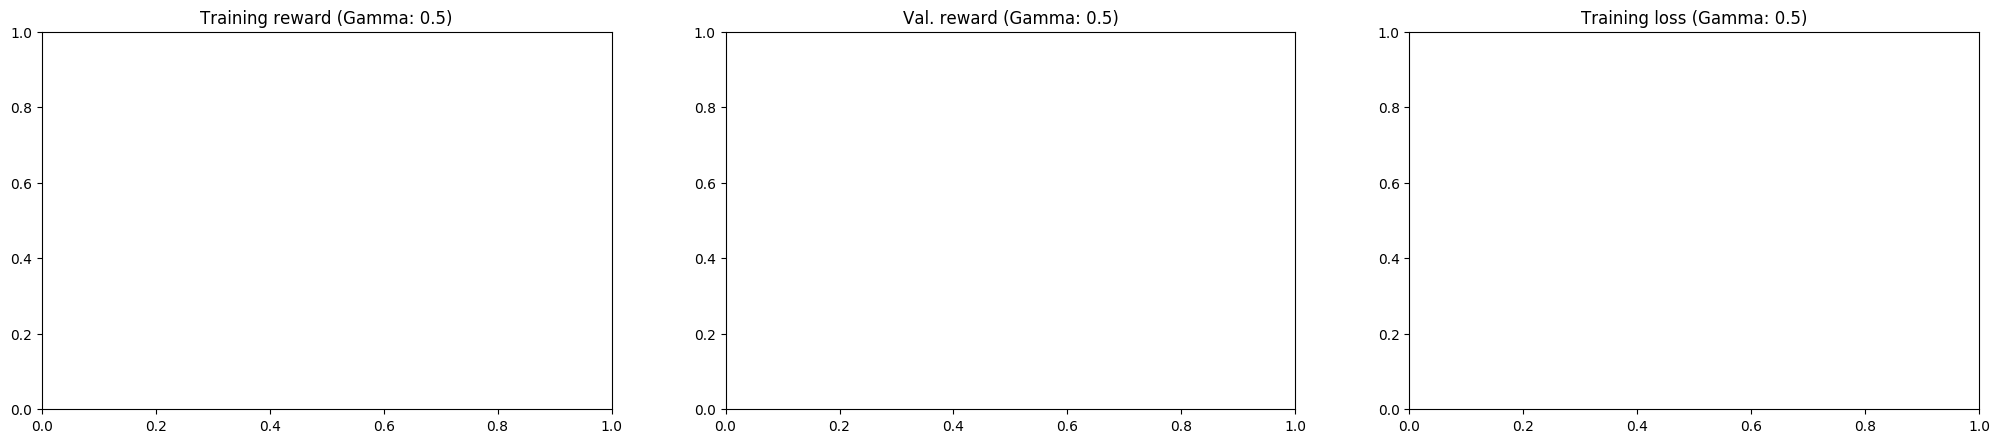

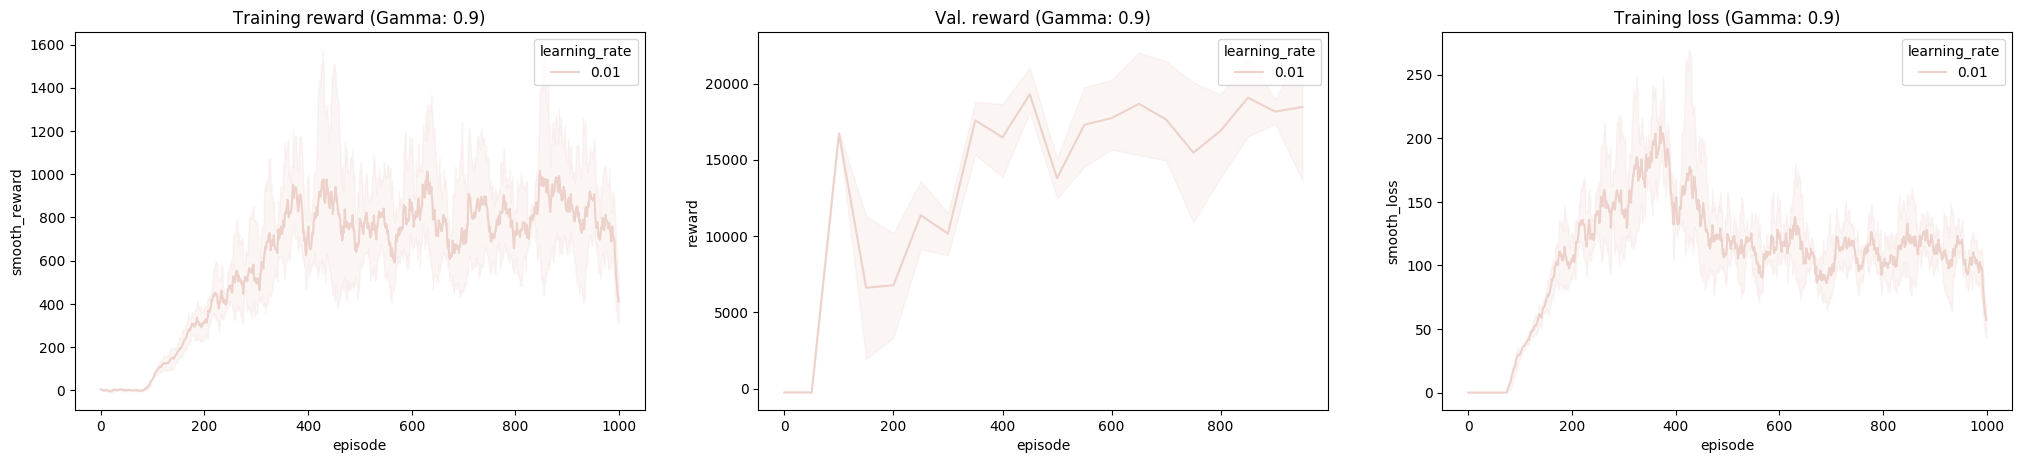

KeyboardInterrupt: 

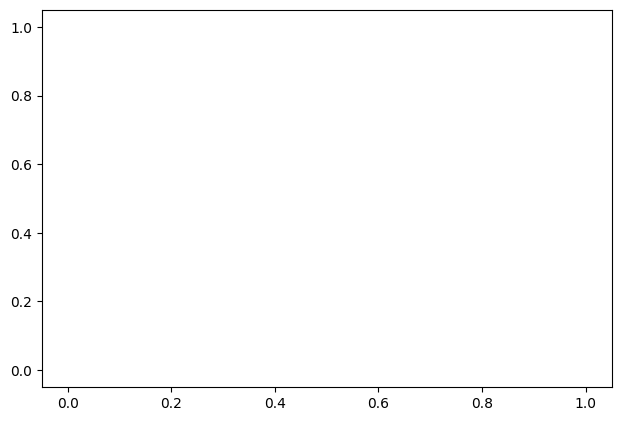

In [22]:
import seaborn as sns
for resolution in [None, 42, 10, 5]:
    for gamma in [0.9, 0.5]:
        data_tr = all_stats.loc[(all_stats.validation==0) & (all_stats.gamma == gamma) & (all_stats.resolution == resolution)]
        data_val = all_stats.loc[(all_stats.validation==1) & (all_stats.gamma == gamma) & (all_stats.resolution == resolution)]

        plt.figure(figsize = (25,5),dpi=100)
        plt.subplot(1,3,1)
        sns.lineplot(data=data_tr,x='episode',y='smooth_reward',hue='learning_rate')
        plt.title('Training reward (Gamma: {})'.format(gamma))

        plt.subplot(1,3,2)
        sns.lineplot(data=data_val,x='episode',y='reward',hue='learning_rate')
        plt.title('Val. reward (Gamma: {})'.format(gamma))

        plt.subplot(1,3,3)
        sns.lineplot(data=data_tr,x='episode',y='smooth_loss',hue='learning_rate')
        plt.title('Training loss (Gamma: {})'.format(gamma))


        plt.show()

In [15]:
data_tr

,episode,step_count,wall_collisions,box_collisions,endless_loops,reward,epsilon,train_loss,validation,complexity,resolution,seed,model_name,gamma,learning_rate,smooth_reward,smooth_loss
1,0,0,0,0,0,0.0,0.943475,0.000000,0,plain,42,0,exp0_plain_phos42_gamma05_LR0005_S0,0.5,0.005,0.525,0.000000
2,1,35,6,1,0,5.7,0.950000,0.000000,0,plain,42,0,exp0_plain_phos42_gamma05_LR0005_S0,0.5,0.005,0.590,0.000000
3,2,13,1,1,0,2.5,0.950000,0.000000,0,plain,42,0,exp0_plain_phos42_gamma05_LR0005_S0,0.5,0.005,0.600,0.000000
4,3,18,6,0,1,-3.9,0.950000,0.000000,0,plain,42,0,exp0_plain_phos42_gamma05_LR0005_S0,0.5,0.005,0.545,0.000000
5,4,22,2,1,0,1.8,0.950000,0.000000,0,plain,42,0,exp0_plain_phos42_gamma05_LR0005_S0,0.5,0.005,0.095,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,795,20,0,1,0,15.9,0.050000,4.621288,0,plain,50,0,exp0_plain_phos50_gamma05_LR01_S0,0.5,0.100,6.525,2.054000
12956,796,7,0,1,0,4.0,0.050000,1.344431,0,plain,50,0,exp0_plain_phos50_gamma05_LR01_S0,0.5,0.100,6.125,1.919009
12957,797,7,0,1,0,4.0,0.050000,1.676221,0,plain,50,0,exp0_plain_phos50_gamma05_LR01_S0,0.5,0.100,5.725,1.801097
12958,798,19,0,1,0,16.0,0.050000,4.132012,0,plain,50,0,exp0_plain_phos50_gamma05_LR01_S0,0.5,0.100,5.525,1.719813


In [ ]:
MODEL_NAME = 'exp1_plain_phos50_S0'

stats = all_stats.loc[all_stats.model_name==MODEL_NAME]

plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
sns.lineplot(data= stats.loc[stats.validation==0],x='episode', y='reward')
plt.plot(np.convolve(stats.loc[stats.validation==0].reward,np.ones(10)/10,mode='valid'))
plt.title('training performance')
plt.legend(['training_reward', 'running average (N=10)'])
plt.subplot(1,2,2)
sns.lineplot(data= stats.loc[stats.validation==1],x='episode', y='reward')
plt.title('validation performance')
plt.legend(['validation_reward'])
plt.show()


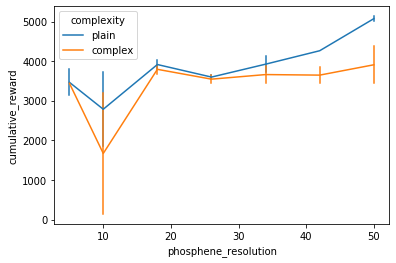

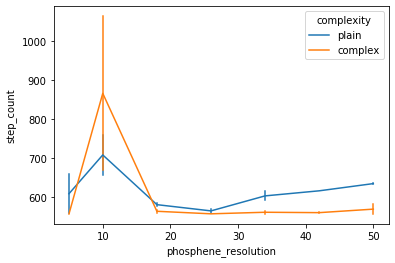

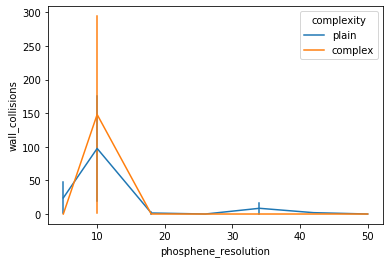

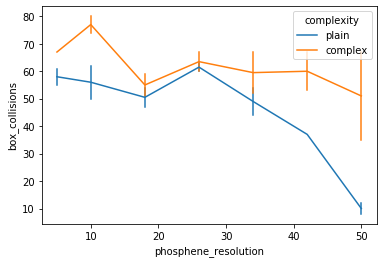

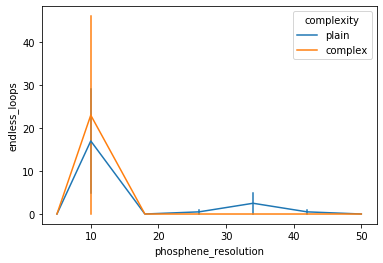

In [46]:
test_results = pd.read_csv(os.path.join(OUT_PATH,'_test_results.csv'))
data = test_results.loc[test_results.gamma == 0.5]

for y in ['cumulative_reward', 'step_count', 'wall_collisions', 'box_collisions', 'endless_loops']:
    sns.lineplot(data=data, x='phosphene_resolution',y=y,hue='complexity', err_style= 'bars')
    plt.show()

In [42]:
test_results

,complexity,phosphene_resolution,seed,gamma,learning_rate,wall_collisions,box_collisions,endless_loops,step_count,cumulative_reward
0,plain,5.0,0,0.5,0.01,47,61,0,658,3139
1,complex,5.0,0,0.5,0.01,0,67,0,556,3440
2,plain,5.0,0,0.9,0.01,2514,89,539,3263,-22168
3,complex,5.0,0,0.9,0.01,0,67,0,556,3440
4,plain,10.0,0,0.5,0.01,20,50,5,657,3713
...,...,...,...,...,...,...,...,...,...,...
59,complex,50.0,1,0.9,0.01,0,27,0,599,4619
60,plain,NaN,1,0.5,0.01,0,1,0,638,5338
61,complex,NaN,1,0.5,0.01,0,6,0,615,5211
62,plain,NaN,1,0.9,0.01,0,3,0,632,5284


In [ ]:
all_stats

In [ ]:
val = all_stats.loc[all_stats.validation==1].reset_index()

In [ ]:
sns.lineplot(data=val,x='episode',y='box_collisions')
plt.show()
sns.lineplot(data=val,x='episode',y='reward')